### AIT 614 - Big Data Essentials <br>
#### Final Project

####Dataset Preparation
In the first step, we read our data set which is a csv file, and show the schema of the dataset.

In [0]:

dataset = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/hsalemi@gmu.edu/emissions1.csv", inferSchema ="true")
dataset.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Local Authority: string (nullable = true)
 |-- Calendar Year: integer (nullable = true)
 |-- LA CO2 Sector: string (nullable = true)
 |-- LA CO2 Sub-sector: string (nullable = true)
 |-- Territorial emissions (kt CO2): double (nullable = true)
 |-- Emissions within the scope of influence of LAs (kt CO2): double (nullable = true)
 |-- Mid-year Population (thousands): double (nullable = true)
 |-- Area (km2): double (nullable = true)



Then, we split data into training and test sets randomly.

In [0]:
trainDF, testDF = dataset.randomSplit([0.8, 0.2], seed=42)

We want th create a regression model to predict Territorial emissions (kt CO2) based on other features of our dataset. The statistics of this attribute in our dataset is as follows:

In [0]:
display(trainDF.select('Territorial emissions (kt CO2)').summary())

summary,Territorial emissions (kt CO2)
count,103544
mean,50.79564556584921
stddev,158.07766658651778
min,-2399.745071
25%,1.666120331
50%,15.42221729
75%,65.48549226
max,9386.233678


####Feature preprocessing
As we can see in the displayed schema, there are some categorical features with string data type. In this step, we select these categorical features including "Country", "Region" , "Local Authority", "Calendar Year", "LA CO2 Sector", "LA CO2 Sub-sector" and convert them to index vector using stringIndexer(). Although the type of the feature "Calendar Year" is Integer, it is considered as a categorical feature here.

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

categoricalCols = ["Country", "Region" , "Local Authority", "Calendar Year", "LA CO2 Sector", "LA CO2 Sub-sector"]

# The following two lines are estimators. They return functions that we will later apply to transform the dataset.

stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "Index" for x in categoricalCols]) 

encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalCols]) 


In the next step, we select our numeric features: 'Emissions within the scope of influence of LAs (kt CO2)', 'Mid-year Population (thousands)', 'Area (km2)', and combine all feature columns into a single feature vector.

In [0]:
from pyspark.ml.feature import VectorAssembler

# This includes both the numeric columns and the one-hot encoded binary vector columns in our dataset.


numericCols = [ 'Emissions within the scope of influence of LAs (kt CO2)', 'Mid-year Population (thousands)', 'Area (km2)']

assemblerInputs = [c + "OHE" for c in categoricalCols] + numericCols

vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")


####Model Developement
In this project, we use linear regression and random forest regression model as the most common regression models for predicting 'Territorial emissions (kt CO2)' based on the features we created in previous steps.

In [0]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor


rf = LinearRegression(labelCol='Territorial emissions (kt CO2)', featuresCol="features")
rforest = RandomForestRegressor(labelCol='Territorial emissions (kt CO2)', featuresCol="features")

To do this, we have used LinearRegression model and RandomForestRegressor model of Pyspark, and created pipelines as follows for processing the data:

In [0]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stringIndexer, encoder,vecAssembler,rf])
pipeline_rforest = Pipeline(stages=[stringIndexer, encoder,vecAssembler,rforest])

Now we can create the model based on the defined pipeline and our training set. Then we apply the model to the testing dataset.

######For Linear Regression

In [0]:
# Define the pipeline model.

pipelineModel = pipeline.fit(trainDF)

# Apply the pipeline model to the test dataset.

predDF = pipelineModel.transform(testDF)

######For Random Forest Regression

In [0]:
# Define the pipeline model.

pipelineModel_rforest = pipeline_rforest.fit(trainDF)

# Apply the pipeline model to the test dataset.

predDF_rforest = pipelineModel_rforest.transform(testDF)

We can acheive the coefficients and the intercept of our linear regression model by the following commands:

In [0]:
print("Coefficients: " + str(pipelineModel.stages[-1].coefficients))
print("Intercept: " + str(pipelineModel.stages[-1].intercept))

Coefficients: [-1.2506335885662418,-0.1641648382458243,1.9844500054355372,-2.5394633480172364,-0.6334316607383963,-0.39304827395642217,-0.1441661216642737,-0.1641648382458243,-3.6279145385948293,-0.9856141886293569,0.1981658956096407,1.9844500054355372,7.336226355217935,7.641129033082468,-4.286200861114239,-6.1773894004453025,-7.994880809669646,3.239275663381179,-4.628030342495524,-4.88514860977455,21.454848690381418,-6.799828396891264,-9.266790975802625,-17.62007556916437,-5.520147180393894,-15.353624806275501,-5.064847581214489,-8.81199093487465,-5.6433318702446575,-10.138662146213868,2.969871809492572,-14.378643228057127,-1.840113421338037,-11.324541570764248,-5.535178397868743,-10.387462774811242,-14.535704328627926,-5.575482137828211,282.5097147180764,-6.253863024482459,3.5849840336861716,-9.147712036022744,-3.6449998011910063,-2.300609277765199,-7.129276040905304,9.617943635548558,36.69033643563518,-6.872853073562774,-6.756933453907485,-13.643482073035555,-9.7687018037877,2.12704

####Model Evaluation
In this project, to evaluate the trained model, we have used RegressionEvaluator to evaluate three metrics including RMSE, MAE, and R-squared on the predicted data frame. Also, we show the table of predicted result for 10 instances to show some predicted instances and their comparison with the original test data.

######For Linear Regression

In [0]:
predDF.select("features", 'Territorial emissions (kt CO2)', "prediction").show(10)

from pyspark.ml.evaluation import RegressionEvaluator

rmse = RegressionEvaluator(labelCol='Territorial emissions (kt CO2)', predictionCol="prediction", metricName="rmse")
rmse = rmse.evaluate(predDF)
mae = RegressionEvaluator(labelCol='Territorial emissions (kt CO2)', predictionCol="prediction", metricName="mae")
mae = mae.evaluate(predDF)
r2 = RegressionEvaluator(labelCol='Territorial emissions (kt CO2)', predictionCol="prediction", metricName="r2")
r2 = r2.evaluate(predDF)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)


+--------------------+------------------------------+-------------------+
|            features|Territorial emissions (kt CO2)|         prediction|
+--------------------+------------------------------+-------------------+
|(437,[0,6,249,403...|                   34.19377219|  36.00557695918631|
|(437,[0,6,249,403...|                   9.618588174| 13.417201067203646|
|(437,[0,6,249,403...|                   148.7943611| 150.46409271184092|
|(437,[0,6,249,403...|                  -8.716263089|-4.8975635031432585|
|(437,[0,6,249,403...|                   148.2851971|  150.0052418436186|
|(437,[0,6,249,398...|                   72.50812577|   72.6246261853056|
|(437,[0,6,249,398...|                   89.25600744|  89.96327460021038|
|(437,[0,6,249,398...|                  -8.987027101| -6.219232264688662|
|(437,[0,6,249,404...|                    64.5932462|  62.25867603960882|
|(437,[0,6,249,404...|                    25.4514416| 23.488219448975727|
+--------------------+----------------

######For Random Forest Regression

In [0]:
predDF_rforest.select("features", 'Territorial emissions (kt CO2)', "prediction").show(10)

from pyspark.ml.evaluation import RegressionEvaluator

rmse_rforest = RegressionEvaluator(labelCol='Territorial emissions (kt CO2)', predictionCol="prediction", metricName="rmse")
rmse_rforest = rmse_rforest.evaluate(predDF_rforest)
mae_rforest = RegressionEvaluator(labelCol='Territorial emissions (kt CO2)', predictionCol="prediction", metricName="mae")
mae_rforest = mae_rforest.evaluate(predDF_rforest)
r2_rforest = RegressionEvaluator(labelCol='Territorial emissions (kt CO2)', predictionCol="prediction", metricName="r2")
r2_rforest = r2_rforest.evaluate(predDF_rforest)

print("RMSE: ", rmse_rforest)
print("MAE: ", mae_rforest)
print("R-squared: ", r2_rforest)

+--------------------+------------------------------+------------------+
|            features|Territorial emissions (kt CO2)|        prediction|
+--------------------+------------------------------+------------------+
|(437,[0,6,249,403...|                   34.19377219|  27.3467360103402|
|(437,[0,6,249,403...|                   9.618588174| 26.17412851678788|
|(437,[0,6,249,403...|                   148.7943611|155.48698547244481|
|(437,[0,6,249,403...|                  -8.716263089|7.7192624544296295|
|(437,[0,6,249,403...|                   148.2851971| 160.9474676261326|
|(437,[0,6,249,398...|                   72.50812577|56.653224082836594|
|(437,[0,6,249,398...|                   89.25600744| 54.28722813492376|
|(437,[0,6,249,398...|                  -8.987027101|7.7192624544296295|
|(437,[0,6,249,404...|                    64.5932462| 55.21654114416587|
|(437,[0,6,249,404...|                    25.4514416|  27.3467360103402|
+--------------------+-----------------------------

Furthermore, we can evaluate the accuracy of our model's prediction by visualizing and comparing the predicted data and the original test dat. Here, we have used matplotlib to plot the predicted and original data simultaneously for a specific range of our test data.

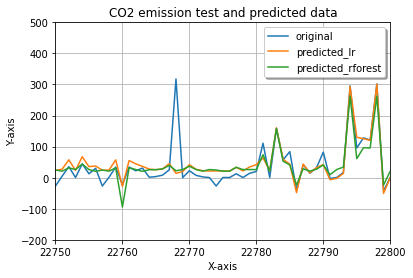

In [0]:
x_ax = range(0, predDF.count())
y_pred_rforest=predDF_rforest.select("prediction").collect()
y_pred=predDF.select("prediction").collect()
y_orig=predDF.select('Territorial emissions (kt CO2)').collect()

 
import matplotlib.pyplot as plt
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted_lr")
plt.plot(x_ax, y_pred_rforest, label="predicted_rforest")
plt.title("CO2 emission test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.xlim([22750, 22800])
plt.ylim([-200, 500])
plt.show() 

Finally, to find better model we can use Hyperparameter tuningand with cross validation technique. We have used ParamGridBuilder() and CrossValidator() to tune the model to find a more accurate model based on RMSE metric.

######For Linear Regression

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrparamGrid = (ParamGridBuilder()
             .addGrid(rf.regParam, [0.01, 0.1, 0.5])
             .addGrid(rf.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(rf.maxIter, [1, 5, 10])
             .build())

# Evaluate model
lrevaluator = RegressionEvaluator(predictionCol="prediction", labelCol='Territorial emissions (kt CO2)', metricName="rmse")

# Create 5-fold CrossValidator
lrcv = CrossValidator(estimator = pipeline,
                    estimatorParamMaps = lrparamGrid,
                    evaluator = lrevaluator,
                    numFolds = 5)

# Run cross validations
lrcvModel = lrcv.fit(trainDF)


In [0]:


# Get Model Summary Statistics
lrcvSummary = lrcvModel.bestModel.stages[-1].summary
#print("Coefficient Standard Errors: " + str(lrcvSummary.coefficientStandardErrors))
#print("P Values: " + str(lrcvSummary.pValues)) # Last element is the intercept

# Use test set here so we can measure the accuracy of our model on new data
lrpredictions = lrcvModel.transform(testDF)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('RMSE:', lrevaluator.evaluate(lrpredictions))

lrevaluator2 = RegressionEvaluator(predictionCol="prediction", labelCol='Territorial emissions (kt CO2)', metricName="r2")
print('R-squared:', lrevaluator2.evaluate(lrpredictions))

RMSE: 165.44982456202652
R-squared: 0.2225444726682233


######For Random Forest Regression

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrparamGrid_rforest = (ParamGridBuilder()
             .addGrid(rforest.maxDepth, [2, 5, 10])
             .addGrid(rforest.maxBins, [5, 10, 20])
             .addGrid(rforest.numTrees, [5, 20, 50])
             .build())

# Evaluate model
lrevaluator_rforest = RegressionEvaluator(predictionCol="prediction", labelCol='Territorial emissions (kt CO2)', metricName="rmse")

# Create 5-fold CrossValidator
lrcv_rforest = CrossValidator(estimator = pipeline_rforest,
                    estimatorParamMaps = lrparamGrid_rforest,
                    evaluator = lrevaluator_rforest,
                    numFolds = 5)

# Run cross validations
lrcvModel_rforest = lrcv_rforest.fit(trainDF)


In [0]:
lrpredictions_rforest = lrcvModel_rforest.transform(testDF)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('RMSE:', lrevaluator_rforest.evaluate(lrpredictions_rforest))

lrevaluator_rforest2 = RegressionEvaluator(predictionCol="prediction", labelCol='Territorial emissions (kt CO2)', metricName="r2")
print('R-squared:', lrevaluator_rforest2.evaluate(lrpredictions_rforest))


RMSE: 68.20767055276308
R-squared: 0.8678675861785929


##### References: <br>
[1] Dr. Liao’s Code Examples & Tutorials: Blackboard/Getting Started with MLlib.html

[2] PySpark: https://spark.apache.org/docs/2.4.0/api/python/pyspark.html

[3] Spark: https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.DataFrame.summary.html

[4] Colby T. Ford: https://gist.github.com/colbyford/184097b0ec37b2b35667dab2da57d349

[5] DataTechNotes: https://www.datatechnotes.com/2022/03/pyspark-regression-example-with.html

[6] Susan Li: https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a